This notebook documents part 1 of the complementarity of image and demographic information: the ability of demographics to predict mode choice and trip generation.

In [2]:
import sys
sys.path.append("models/")

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import entropy
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dataloader import SurveyDataset, load_demo, load_aggregate_travel_behavior, train_test_split
import mnl
import linear_reg
from setup import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_version = '1571'
variable_names = ['active','auto','mas','pt','trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']


In [4]:
# target variables y

file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, data_version)

train_test_index = df_pivot['train_test'].astype(bool)
y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index, :4]
y_test = y[train_test_index, :4]

In [5]:
sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)

In [6]:
# explanatory variables x

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

demo_cs, demo_np = load_demo(data_dir)
demo = np.hstack((np.array(demo_cs).reshape(-1,1), demo_np))
demo = pd.DataFrame(demo, columns = ['geoid'] + demo_variables)
demo_split = train_test_split(demo, data_version)

x_train = demo_split[~demo_split['train_test'].astype(bool)][demo_variables].to_numpy(dtype=float)
x_test = demo_split[demo_split['train_test'].astype(bool)][demo_variables].to_numpy(dtype=float)


In [11]:
y.mean(axis=0)

array([ 0.1173614 ,  0.77258279,  0.04028305,  0.06977276, 13.70586056])

In [13]:
auto_train = y[~train_test_index,1]
auto_test = y[train_test_index,1]

pt_train = y[~train_test_index,3]
pt_test = y[train_test_index,3]

active_train = y[~train_test_index,0]
active_test = y[train_test_index,0]

trpgen_train = y[~train_test_index,-1]
trpgen_test = y[train_test_index,-1]

# 1. Linear Regresion

Highlight:

Auto

Parameter: 0.00e+00 Train R2: 0.4444 	 Test R: 0.5033

PT

Parameter: 0.00e+00 Train R2: 0.3893 	 Test R: 0.2894

Active

Parameter: 0.00e+00 Train R2: 0.3505 	 Test R: 0.4702

Trip Generation

Ridge Parameter: 4.00e+00 Train R2: 0.2159 	 Test R: 0.1730

Lasso Parameter: 1.00e-02 Train R2: 0.2387 	 Test R: 0.1578 	 Nonzero coef: 7


### 1.1 Auto Share

In [32]:
# Linear Regression without Regularization
lr = linear_model.LinearRegression()
lr.fit(x_train, auto_train)
# with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#     f.write("%s,%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], -1, 
#         lr.score(x_train, auto_train), lr.score(x_test, auto_test), 'lr', zoomlevel,
#         np.sum(lr.coef_ != 0), len(lr.coef_)))
print("Train R2: %.4f \t Test R2: %.4f" % (lr.score(x_train, auto_train), lr.score(x_test, auto_test)))

Train R2: 0.4444 	 Test R2: 0.5033


In [192]:
# Lasso
for a in (1e-4)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, auto_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, auto_train), 
                                                                                  lasso.score(x_test, auto_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

Parameter: 0.00e+00 Train R2: 0.4444 	 Test R: 0.5033 	 Nonzero coef: 10
Parameter: 1.00e-05 Train R2: 0.4444 	 Test R: 0.5031 	 Nonzero coef: 10
Parameter: 1.00e-04 Train R2: 0.4436 	 Test R: 0.5018 	 Nonzero coef: 10
Parameter: 2.00e-04 Train R2: 0.4413 	 Test R: 0.4997 	 Nonzero coef: 10
Parameter: 3.00e-04 Train R2: 0.4403 	 Test R: 0.4991 	 Nonzero coef: 8
Parameter: 4.00e-04 Train R2: 0.4395 	 Test R: 0.4986 	 Nonzero coef: 8
Parameter: 5.00e-04 Train R2: 0.4384 	 Test R: 0.4979 	 Nonzero coef: 8
Parameter: 6.00e-04 Train R2: 0.4372 	 Test R: 0.4970 	 Nonzero coef: 7
Parameter: 7.00e-04 Train R2: 0.4360 	 Test R: 0.4959 	 Nonzero coef: 7
Parameter: 8.00e-04 Train R2: 0.4347 	 Test R: 0.4947 	 Nonzero coef: 7
Parameter: 1.00e-03 Train R2: 0.4315 	 Test R: 0.4918 	 Nonzero coef: 7
Parameter: 2.00e-03 Train R2: 0.4149 	 Test R: 0.4724 	 Nonzero coef: 5
Parameter: 5.00e-03 Train R2: 0.3792 	 Test R: 0.4217 	 Nonzero coef: 4


/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e+01, tolerance: 7.704e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

In [194]:
# Ridge

for a in (1e+1)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, auto_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, auto_train), 
                                                              ridge.score(x_test, auto_test)))

Parameter: 0.00e+00 Train R2: 0.4444 	 Test R: 0.5033
Parameter: 1.00e+00 Train R2: 0.4426 	 Test R: 0.5008
Parameter: 1.00e+01 Train R2: 0.4197 	 Test R: 0.4778
Parameter: 2.00e+01 Train R2: 0.3918 	 Test R: 0.4469
Parameter: 3.00e+01 Train R2: 0.3660 	 Test R: 0.4171
Parameter: 4.00e+01 Train R2: 0.3430 	 Test R: 0.3900
Parameter: 5.00e+01 Train R2: 0.3224 	 Test R: 0.3655
Parameter: 6.00e+01 Train R2: 0.3041 	 Test R: 0.3437
Parameter: 7.00e+01 Train R2: 0.2878 	 Test R: 0.3241
Parameter: 8.00e+01 Train R2: 0.2731 	 Test R: 0.3065
Parameter: 1.00e+02 Train R2: 0.2478 	 Test R: 0.2763
Parameter: 2.00e+02 Train R2: 0.1701 	 Test R: 0.1845
Parameter: 5.00e+02 Train R2: 0.0888 	 Test R: 0.0919


### 1.2 PT

In [85]:
# Linear Regression without Regularization
lr = linear_model.LinearRegression()
lr.fit(x_train, pt_train)
# with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#     f.write("%s,%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], -1, 
#         lr.score(x_train, auto_train), lr.score(x_test, auto_test), 'lr', zoomlevel,
#         np.sum(lr.coef_ != 0), len(lr.coef_)))
print("Train R2: %.4f \t Test R2: %.4f" % (lr.score(x_train, pt_train), lr.score(x_test, pt_test)))

Train R2: 0.3893 	 Test R2: 0.2894


In [21]:
# Lasso
for a in (1e-3)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, pt_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, pt_train), 
                                                                                  lasso.score(x_test, pt_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

Parameter: 0.00e+00 Train R2: 0.3893 	 Test R: 0.2894 	 Nonzero coef: 10
Parameter: 1.00e-04 Train R2: 0.3852 	 Test R: 0.2904 	 Nonzero coef: 9
Parameter: 1.00e-03 Train R2: 0.3498 	 Test R: 0.2752 	 Nonzero coef: 5
Parameter: 2.00e-03 Train R2: 0.3167 	 Test R: 0.2463 	 Nonzero coef: 4
Parameter: 3.00e-03 Train R2: 0.2785 	 Test R: 0.2165 	 Nonzero coef: 3
Parameter: 4.00e-03 Train R2: 0.2351 	 Test R: 0.1876 	 Nonzero coef: 3
Parameter: 5.00e-03 Train R2: 0.1792 	 Test R: 0.1461 	 Nonzero coef: 3
Parameter: 6.00e-03 Train R2: 0.1109 	 Test R: 0.0920 	 Nonzero coef: 3
Parameter: 7.00e-03 Train R2: 0.0302 	 Test R: 0.0252 	 Nonzero coef: 3
Parameter: 8.00e-03 Train R2: 0.0000 	 Test R: -0.0000 	 Nonzero coef: 0
Parameter: 1.00e-02 Train R2: 0.0000 	 Test R: -0.0000 	 Nonzero coef: 0
Parameter: 2.00e-02 Train R2: 0.0000 	 Test R: -0.0000 	 Nonzero coef: 0
Parameter: 5.00e-02 Train R2: 0.0000 	 Test R: -0.0000 	 Nonzero coef: 0


/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.191e+00, tolerance: 1.373e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg,

In [22]:
# Ridge

for a in (1e+1)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, pt_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, pt_train), 
                                                              ridge.score(x_test, pt_test)))

Parameter: 0.00e+00 Train R2: 0.3893 	 Test R: 0.2894
Parameter: 1.00e+00 Train R2: 0.3838 	 Test R: 0.2934
Parameter: 1.00e+01 Train R2: 0.3567 	 Test R: 0.2929
Parameter: 2.00e+01 Train R2: 0.3327 	 Test R: 0.2810
Parameter: 3.00e+01 Train R2: 0.3117 	 Test R: 0.2672
Parameter: 4.00e+01 Train R2: 0.2934 	 Test R: 0.2537
Parameter: 5.00e+01 Train R2: 0.2774 	 Test R: 0.2411
Parameter: 6.00e+01 Train R2: 0.2632 	 Test R: 0.2295
Parameter: 7.00e+01 Train R2: 0.2507 	 Test R: 0.2189
Parameter: 8.00e+01 Train R2: 0.2394 	 Test R: 0.2093
Parameter: 1.00e+02 Train R2: 0.2200 	 Test R: 0.1924
Parameter: 2.00e+02 Train R2: 0.1594 	 Test R: 0.1386
Parameter: 5.00e+02 Train R2: 0.0912 	 Test R: 0.0782


### 1.3 Active

In [23]:
for a in (1e-3)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, active_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, active_train), 
                                                                                  lasso.score(x_test, active_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

Parameter: 0.00e+00 Train R2: 0.3505 	 Test R: 0.4702 	 Nonzero coef: 10
Parameter: 1.00e-04 Train R2: 0.3500 	 Test R: 0.4715 	 Nonzero coef: 9
Parameter: 1.00e-03 Train R2: 0.3310 	 Test R: 0.4598 	 Nonzero coef: 6
Parameter: 2.00e-03 Train R2: 0.3152 	 Test R: 0.4355 	 Nonzero coef: 4
Parameter: 3.00e-03 Train R2: 0.2995 	 Test R: 0.4077 	 Nonzero coef: 4
Parameter: 4.00e-03 Train R2: 0.2776 	 Test R: 0.3734 	 Nonzero coef: 4
Parameter: 5.00e-03 Train R2: 0.2495 	 Test R: 0.3325 	 Nonzero coef: 3
Parameter: 6.00e-03 Train R2: 0.2281 	 Test R: 0.3004 	 Nonzero coef: 2
Parameter: 7.00e-03 Train R2: 0.2030 	 Test R: 0.2641 	 Nonzero coef: 2
Parameter: 8.00e-03 Train R2: 0.1739 	 Test R: 0.2237 	 Nonzero coef: 2
Parameter: 1.00e-02 Train R2: 0.1043 	 Test R: 0.1304 	 Nonzero coef: 2
Parameter: 2.00e-02 Train R2: 0.0000 	 Test R: -0.0003 	 Nonzero coef: 0
Parameter: 5.00e-02 Train R2: 0.0000 	 Test R: -0.0003 	 Nonzero coef: 0


/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.231e+01, tolerance: 3.791e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max

In [33]:
# Ridge

for a in (1e+1)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, active_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, active_train), 
                                                              ridge.score(x_test, active_test)))

Parameter: 0.00e+00 Train R2: 0.3505 	 Test R: 0.4702
Parameter: 1.00e+00 Train R2: 0.3500 	 Test R: 0.4696
Parameter: 1.00e+01 Train R2: 0.3322 	 Test R: 0.4478
Parameter: 2.00e+01 Train R2: 0.3095 	 Test R: 0.4170
Parameter: 3.00e+01 Train R2: 0.2886 	 Test R: 0.3879
Parameter: 4.00e+01 Train R2: 0.2698 	 Test R: 0.3617
Parameter: 5.00e+01 Train R2: 0.2531 	 Test R: 0.3384
Parameter: 6.00e+01 Train R2: 0.2382 	 Test R: 0.3176
Parameter: 7.00e+01 Train R2: 0.2249 	 Test R: 0.2992
Parameter: 8.00e+01 Train R2: 0.2129 	 Test R: 0.2826
Parameter: 1.00e+02 Train R2: 0.1923 	 Test R: 0.2543
Parameter: 2.00e+02 Train R2: 0.1292 	 Test R: 0.1688
Parameter: 5.00e+02 Train R2: 0.0649 	 Test R: 0.0836


### 1.4 Trip Generation

In [203]:
for a in (1e-2)*np.array([0,0.1,0.5,0.8,0.9,1,1.5,2,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, trpgen_train), 
                                                                                  lasso.score(x_test, trpgen_test), 
                                                                                  np.sum(lasso.coef_ != 0)))
#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

Parameter: 0.00e+00 Train R2: 0.2404 	 Test R: 0.1470 	 Nonzero coef: 10
Parameter: 1.00e-03 Train R2: 0.2404 	 Test R: 0.1481 	 Nonzero coef: 10
Parameter: 5.00e-03 Train R2: 0.2399 	 Test R: 0.1534 	 Nonzero coef: 9
Parameter: 8.00e-03 Train R2: 0.2392 	 Test R: 0.1572 	 Nonzero coef: 8
Parameter: 9.00e-03 Train R2: 0.2389 	 Test R: 0.1575 	 Nonzero coef: 8
Parameter: 1.00e-02 Train R2: 0.2387 	 Test R: 0.1578 	 Nonzero coef: 7
Parameter: 1.50e-02 Train R2: 0.2383 	 Test R: 0.1578 	 Nonzero coef: 7
Parameter: 2.00e-02 Train R2: 0.2379 	 Test R: 0.1576 	 Nonzero coef: 7
Parameter: 2.00e-01 Train R2: 0.1799 	 Test R: 0.1072 	 Nonzero coef: 2
Parameter: 5.00e-01 Train R2: 0.0280 	 Test R: 0.0591 	 Nonzero coef: 1


/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+05, tolerance: 3.630e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

In [204]:
# Ridge

for a in (1e0)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, trpgen_train), 
                                                              ridge.score(x_test, trpgen_test)))

Parameter: 0.00e+00 Train R2: 0.2404 	 Test R: 0.1470
Parameter: 1.00e-01 Train R2: 0.2404 	 Test R: 0.1495
Parameter: 1.00e+00 Train R2: 0.2372 	 Test R: 0.1633
Parameter: 2.00e+00 Train R2: 0.2309 	 Test R: 0.1700
Parameter: 3.00e+00 Train R2: 0.2236 	 Test R: 0.1727
Parameter: 4.00e+00 Train R2: 0.2159 	 Test R: 0.1730
Parameter: 5.00e+00 Train R2: 0.2084 	 Test R: 0.1721
Parameter: 6.00e+00 Train R2: 0.2012 	 Test R: 0.1705
Parameter: 7.00e+00 Train R2: 0.1944 	 Test R: 0.1684
Parameter: 8.00e+00 Train R2: 0.1880 	 Test R: 0.1660
Parameter: 1.00e+01 Train R2: 0.1764 	 Test R: 0.1611
Parameter: 2.00e+01 Train R2: 0.1365 	 Test R: 0.1386
Parameter: 5.00e+01 Train R2: 0.0881 	 Test R: 0.1011


# 2. Linear Regression (PyTorch)

Learning Rate very sensitive to data magnitude.

In [305]:
def pytorch_lr(w2_list, lr_list, x1, x2, y1, y2, reg_type='L2'):
    
    mseloss = nn.MSELoss(reduction='sum')
    
    trainset = SurveyDataset(torch.tensor(x1,  dtype=torch.float), torch.tensor(y1, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)

    testset = SurveyDataset(torch.tensor(x2, dtype=torch.float), torch.tensor(y2, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    # decay rates for embedding
    w1_list = [0]
    # decay rates for demo (There is no demo in this case)
#     w2_list = [0]
    # lr_list = [0.005,0.01, 0.02]
#     lr_list = [0.002]

    dim_demo = x1.shape[1]
    dim_embed = 0

    for lr in lr_list:

        for w1, w2 in itertools.product(w1_list, w2_list):

            # model setup
            model = linear_reg.LR(dim_embed=dim_embed, dim_demo=dim_demo)

#             print(model)
            embed_params = []
            demo_params = []
            other_params = []
            for name, m in model.named_parameters():
        #             print(name)
                if 'embed' in name:
                    embed_params.append(m)
                elif 'demo' in name:
                    demo_params.append(m)
                else:
                    other_params.append(m)

#             optimizer = torch.optim.Adam([{'params':demo_params,'lr':lr}])
            if reg_type == 'L2':
                optimizer = torch.optim.Adam([{'params':embed_params,'weight_decay':w1,'lr':lr},
                                          {'params':demo_params,'weight_decay':w2, 'lr':lr},
                                          {'params':other_params,'weight_decay':0, 'lr':lr}])
            else:
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#             print(optimizer)
#             print(demo_params)
            
            # model training
            ref1 = 0
            ref2 = 0

            for epoch in range(5000):

                mse_ = 0

                for batch, (x_batch, y_batch) in enumerate(trainloader):
                    # Compute prediction and loss
                    pred = model(None, x_batch)
                    pred = F.relu(pred).squeeze()

                    mse = mseloss(pred, y_batch)
                    mse_ += mse.item()

                    if reg_type == 'L1':
                        l1_reg = w2 * torch.norm(demo_params, 1)
                        mse += l1_reg
                    
                    # Backpropagation
                    optimizer.zero_grad()
                    mse.backward()
                    optimizer.step()

                train_r = r2_score(y_batch.numpy(), pred.detach().numpy())
                train_mse = mse_/len(trainset)

                if epoch % 20 == 0:
                    print(f"[epoch: {epoch:>3d}] Train MSE : {train_mse:.4f} R2 score: {train_r:.3f} ")
                loss_ = train_mse

                if epoch % 5 == 0:
                    if epoch >=40:
                        if (np.abs(loss_ - ref1)/ref1<0.0005) & (np.abs(loss_ - ref2)/ref2<0.0005):
                            print("Early stopping at epoch", epoch)
                            print(ref2, ref1, loss_)
                            break
                        if (ref1 < loss_) & (ref1 < ref2):
                            print("Diverging. stop.")
                            break
                        if loss_ < best:
                            best = loss_
                            best_epoch = epoch
                    else:
                        best = loss_
                        best_epoch = epoch

                    ref2 = ref1
                    ref1 = loss_

                if epoch % 20 == 0:

                    mse_ = 0 

                    for batch, (x_batch, y_batch) in enumerate(testloader):
                        pred = model(None, x_batch)
                        pred = F.relu(pred).squeeze()

                        mse = mseloss(pred, y_batch)
                        mse_ += mse.item()
                        
#                     print(len(testset))

                    test_mse = mse_/len(testset)
                    test_r = r2_score(y_batch.numpy(),pred.detach().numpy())

                    print(f"[epoch: {epoch:>3d}] Test MSE {test_mse:.4f} R2 score: {test_r:.3f} ")
    return model
    #         with open(out_dir+model_code+"_regression_trpgen.csv", "a") as f:
    #             f.write("%s,%s,%s,%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
    #                 (model_run_date, model_type, zoomlevel, "LR", lr, w1, 
    #                   train_rmse, train_r, test_rmse, test_r))

In [304]:
model = pytorch_lr(w2_list=[0], lr_list=[0.02], x1=x_train, x2=x_test, y1=auto_train, y2=auto_test)


[epoch:   0] Train MSE : 0.6450 R2 score: -10.838 
[epoch:   0] Test MSE 0.6247 R2 score: -11.327 
[epoch:  20] Train MSE : 0.1336 R2 score: -1.452 
[epoch:  20] Test MSE 0.1245 R2 score: -1.457 
[epoch:  40] Train MSE : 0.0758 R2 score: -0.391 
[epoch:  40] Test MSE 0.0762 R2 score: -0.503 
[epoch:  60] Train MSE : 0.0605 R2 score: -0.110 
[epoch:  60] Test MSE 0.0610 R2 score: -0.204 
[epoch:  80] Train MSE : 0.0496 R2 score: 0.089 
[epoch:  80] Test MSE 0.0491 R2 score: 0.032 
[epoch: 100] Train MSE : 0.0433 R2 score: 0.205 
[epoch: 100] Test MSE 0.0421 R2 score: 0.170 
[epoch: 120] Train MSE : 0.0397 R2 score: 0.271 
[epoch: 120] Test MSE 0.0379 R2 score: 0.253 
[epoch: 140] Train MSE : 0.0377 R2 score: 0.308 
[epoch: 140] Test MSE 0.0354 R2 score: 0.302 
[epoch: 160] Train MSE : 0.0365 R2 score: 0.330 
[epoch: 160] Test MSE 0.0338 R2 score: 0.332 
[epoch: 180] Train MSE : 0.0357 R2 score: 0.344 
[epoch: 180] Test MSE 0.0328 R2 score: 0.354 
[epoch: 200] Train MSE : 0.0351 R2 score

In [241]:
model = pytorch_lr(w2_list=[0], lr_list=[0.003], x1=x_train, x2=x_test, y1=pt_train, y2=pt_test)


[epoch:   0] Train MSE : 0.0209 R2 score: -1.151 
[epoch:   0] Test MSE 0.0165 R2 score: -0.770 
[epoch:  20] Train MSE : 0.0128 R2 score: -0.324 
[epoch:  20] Test MSE 0.0119 R2 score: -0.276 
[epoch:  40] Train MSE : 0.0119 R2 score: -0.231 
[epoch:  40] Test MSE 0.0112 R2 score: -0.205 
[epoch:  60] Train MSE : 0.0110 R2 score: -0.131 
[epoch:  60] Test MSE 0.0098 R2 score: -0.050 
[epoch:  80] Train MSE : 0.0097 R2 score: -0.004 
[epoch:  80] Test MSE 0.0085 R2 score: 0.085 
[epoch: 100] Train MSE : 0.0088 R2 score: 0.092 
[epoch: 100] Test MSE 0.0079 R2 score: 0.154 
[epoch: 120] Train MSE : 0.0082 R2 score: 0.160 
[epoch: 120] Test MSE 0.0075 R2 score: 0.194 
[epoch: 140] Train MSE : 0.0077 R2 score: 0.209 
[epoch: 140] Test MSE 0.0073 R2 score: 0.221 
[epoch: 160] Train MSE : 0.0073 R2 score: 0.246 
[epoch: 160] Test MSE 0.0071 R2 score: 0.237 
[epoch: 180] Train MSE : 0.0071 R2 score: 0.273 
[epoch: 180] Test MSE 0.0070 R2 score: 0.247 
[epoch: 200] Train MSE : 0.0068 R2 score:

In [242]:
model = pytorch_lr(w2_list=[0], lr_list=[0.005], x1=x_train, x2=x_test, y1=active_train, y2=active_test)


[epoch:   0] Train MSE : 0.0406 R2 score: -0.514 
[epoch:   0] Test MSE 0.0378 R2 score: -0.537 
[epoch:  20] Train MSE : 0.0265 R2 score: 0.011 
[epoch:  20] Test MSE 0.0239 R2 score: 0.031 
[epoch:  40] Train MSE : 0.0222 R2 score: 0.172 
[epoch:  40] Test MSE 0.0196 R2 score: 0.201 
[epoch:  60] Train MSE : 0.0199 R2 score: 0.259 
[epoch:  60] Test MSE 0.0163 R2 score: 0.336 
[epoch:  80] Train MSE : 0.0188 R2 score: 0.297 
[epoch:  80] Test MSE 0.0147 R2 score: 0.401 
[epoch: 100] Train MSE : 0.0184 R2 score: 0.313 
[epoch: 100] Test MSE 0.0140 R2 score: 0.432 
[epoch: 120] Train MSE : 0.0182 R2 score: 0.321 
[epoch: 120] Test MSE 0.0136 R2 score: 0.447 
[epoch: 140] Train MSE : 0.0181 R2 score: 0.326 
[epoch: 140] Test MSE 0.0134 R2 score: 0.456 
[epoch: 160] Train MSE : 0.0179 R2 score: 0.331 
[epoch: 160] Test MSE 0.0132 R2 score: 0.462 
[epoch: 180] Train MSE : 0.0178 R2 score: 0.335 
[epoch: 180] Test MSE 0.0131 R2 score: 0.466 
[epoch: 200] Train MSE : 0.0177 R2 score: 0.338 

In [247]:
model = pytorch_lr(w2_list=[4], lr_list=[0.4], x1=x_train, x2=x_test, y1=trpgen_train, y2=trpgen_test)


[epoch:   0] Train MSE : 442.0938 R2 score: -0.722 
[epoch:   0] Test MSE 380.1566 R2 score: -1.005 
[epoch:  20] Train MSE : 258.4086 R2 score: -0.007 
[epoch:  20] Test MSE 184.4423 R2 score: 0.027 
[epoch:  40] Train MSE : 241.0255 R2 score: 0.061 
[epoch:  40] Test MSE 179.1828 R2 score: 0.055 
[epoch:  60] Train MSE : 236.4879 R2 score: 0.079 
[epoch:  60] Test MSE 177.2693 R2 score: 0.065 
[epoch:  80] Train MSE : 231.7684 R2 score: 0.097 
[epoch:  80] Test MSE 173.2355 R2 score: 0.087 
[epoch: 100] Train MSE : 227.4779 R2 score: 0.114 
[epoch: 100] Test MSE 170.7736 R2 score: 0.100 
[epoch: 120] Train MSE : 223.5468 R2 score: 0.129 
[epoch: 120] Test MSE 168.7242 R2 score: 0.110 
[epoch: 140] Train MSE : 220.0191 R2 score: 0.143 
[epoch: 140] Test MSE 166.9102 R2 score: 0.120 
[epoch: 160] Train MSE : 216.8922 R2 score: 0.155 
[epoch: 160] Test MSE 165.3753 R2 score: 0.128 
[epoch: 180] Train MSE : 214.1471 R2 score: 0.166 
[epoch: 180] Test MSE 164.1018 R2 score: 0.135 
[epoch:

# 3. MNL for mode choice

In [184]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [297]:
def mnl_torch(lr_list, wd_list):
    
    for (lr, wd) in itertools.product(lr_list, wd_list):
        print(f"[lr: {lr:.3f}, wd: {wd:3.4f}]")

        # model setup
        model = mnl.MNL(n_alts=4, n_features=x_train.shape[-1])
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        # model training

        ref1 = 0
        ref2 = 0

        for epoch in range(1000):

            kl_ = 0
            mse_ = 0
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(trainloader):
                # Compute prediction and loss
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util, dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()
                mse = mse.sum()

                # Backpropagation
                optimizer.zero_grad()
                kl.backward()
                optimizer.step()

            train_kl = kl_/len(trainset)
            train_mse = np.sqrt(mse_/len(trainset))
            train_mse1 = np.sqrt(mse1_/len(trainset))
            train_mse2 = np.sqrt(mse2_/len(trainset))
            train_mse3 = np.sqrt(mse3_/len(trainset))
            train_mse4 = np.sqrt(mse4_/len(trainset))

            train_r1 = 1-mse1_/sst_train[0]
            train_r2 = 1-mse2_/sst_train[1]
            train_r3 = 1-mse3_/sst_train[2]
            train_r4 = 1-mse4_/sst_train[3]

            loss_ = train_kl

            if epoch % 5 == 0:

                kl_ = 0
                mse_ = 0 
                mse1_ = 0
                mse2_ = 0
                mse3_ = 0
                mse4_ = 0

                for batch, (x_batch, y_batch) in enumerate(testloader):
                    util = model(x_batch)
                    probs = torch.log(nn.functional.softmax(util,dim=1))
                    kl = kldivloss(probs, y_batch)
            #         kl = kldivloss(torch.log(util), y_batch)
                    kl_ += kl.item()

                    mse = mseloss(torch.exp(probs), y_batch)
            #         mse = mseloss(util, y_batch)
                    mse_ += mse.sum().item()
                    mse1_ += mse[:,0].sum().item()
                    mse2_ += mse[:,1].sum().item()
                    mse3_ += mse[:,2].sum().item()
                    mse4_ += mse[:,3].sum().item()

                test_kl = kl_/len(testset)
                test_mse = np.sqrt(mse_/len(testset))
                test_mse1 = np.sqrt(mse1_/len(testset))
                test_mse2 = np.sqrt(mse2_/len(testset))
                test_mse3 = np.sqrt(mse3_/len(testset))
                test_mse4 = np.sqrt(mse4_/len(testset))

                r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
                r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
                r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
                r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

                if epoch >= 40:
                    if (np.abs(loss_ - ref1)/ref1<0.001) & (np.abs(loss_ - ref2)/ref2<0.001):
                        print("Early stopping at epoch", epoch)
                        break
                    if (ref1 < loss_) & (ref1 < ref2):
                        print("Diverging. stop.")
                        break
                    if loss_ < best:
                        best = loss_
                        best_epoch = epoch
                        output = (train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                                  test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                                  r1, r2, r3, r4, train_r1, train_r2, train_r3, train_r4)
                else:
                    best = loss_
                    best_epoch = epoch
                    output = (train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                                  test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                                  r1, r2, r3, r4, train_r1, train_r2, train_r3, train_r4)
                ref2 = ref1
                ref1 = loss_

#             if epoch % 20 == 0:

    #             print(f"[epoch: {epoch:>3d}] Train KL loss: {train_kl:.3f} RMSE {train_mse:.3f} \
    #                 {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
    #             print(f"\t\t\t\t\t\t Train R2 score: {train_r1:.3f} {train_r2:.3f} {train_r3:.3f} {train_r4:.3f} ")
    #             print(f"[epoch: {epoch:>3d}] Test KL loss: {kl_/len(testset):.3f} RMSE {np.sqrt(mse_/len(testset)):.3f} \
    #                     {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
    #             print(f"\t\t\t\t\t\t Test R2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")

#                 print(f"[epoch: {epoch:>3d}] Train KL loss: {train_kl:.3f} Train R2 score: {train_r1:.3f} {train_r2:.3f} {train_r3:.3f} {train_r4:.3f} ")
#                 print(f"[epoch: {epoch:>3d}] Test KL loss: {kl_/len(testset):.3f} Test R2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")

    #     with open(out_dir+"BA_mode_choice.csv", "a") as f:
    #         f.write("%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % 
    #                 (("MNL",lr, wd)+output))
    
        print(f"[epoch: {best_epoch:>3d}] Train KL loss: {output[0]:.3f} Train R2 score: {output[12]:.3f} {output[13]:.3f} {output[14]:.3f} {output[15]:.3f} ")
        print(f"[epoch: {best_epoch:>3d}] Test KL loss: {output[6]:.3f} Test R2 score: {output[16]:.3f} {output[17]:.3f} {output[18]:.3f} {output[19]:.3f} ")
        print()

In [299]:
mnl_torch(lr_list=[0.01], wd_list=[0, 0.0005, 0.001, 0.002, 0.01, 0.1, 1, 10, 100])

[lr: 0.010, wd: 0.0000]
Early stopping at epoch 505
[epoch: 500] Train KL loss: 0.168 Train R2 score: 0.439 0.445 -0.151 0.230 
[epoch: 500] Test KL loss: 0.145 Test R2 score: 0.339 0.414 -0.019 0.337 

[lr: 0.010, wd: 0.0005]
Early stopping at epoch 640
[epoch: 635] Train KL loss: 0.170 Train R2 score: 0.440 0.445 -0.133 0.241 
[epoch: 635] Test KL loss: 0.145 Test R2 score: 0.331 0.409 -0.013 0.323 

[lr: 0.010, wd: 0.0010]
Early stopping at epoch 715
[epoch: 710] Train KL loss: 0.169 Train R2 score: 0.444 0.442 -0.149 0.221 
[epoch: 710] Test KL loss: 0.145 Test R2 score: 0.341 0.415 -0.012 0.312 

[lr: 0.010, wd: 0.0020]
Early stopping at epoch 580
[epoch: 575] Train KL loss: 0.169 Train R2 score: 0.436 0.442 -0.132 0.232 
[epoch: 575] Test KL loss: 0.145 Test R2 score: 0.334 0.410 -0.015 0.333 

[lr: 0.010, wd: 0.0100]
Early stopping at epoch 680
[epoch: 675] Train KL loss: 0.168 Train R2 score: 0.442 0.449 -0.134 0.234 
[epoch: 675] Test KL loss: 0.145 Test R2 score: 0.342 0.418 

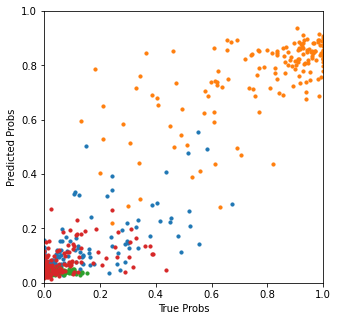

In [265]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(4):
    ax.scatter(y_batch.detach().numpy()[:,i], torch.exp(probs).detach().numpy()[:,i], s=10)

ax.set_xlabel("True Probs")
ax.set_ylabel("Predicted Probs")
ax.set_xlim([0,1])
ax.set_ylim([0,1]);


In [86]:
torch.save(model.state_dict(), out_dir+"demo_weights.pt")